In [ ]:
# Copyright (C) 2024 Takaaki Shiotani

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import sys

import matplotlib.pyplot as plt
import pandas as pd
import pandera as pa
import seaborn as sns

sys.path.append("../src")

from datahandler import DataHandler

sns.set_theme()

In [4]:
data_dir = DataHandler.DATA_DIR
feat_df = pd.read_csv(data_dir / "processed_data.csv")

In [5]:
USED_INDEXES = [1, 2, 3]
feat_df = feat_df[feat_df["sex"] == "female"]
feat_df = feat_df[feat_df["number"].isin(USED_INDEXES)]

In [6]:
feature_cols = [
    "AR", "STD_SPEED", "STDP", "VOL_VAR_GLOBAL", "F1F2R_100",
    "AVG_SILENCE_DURATION_SENTENCE",
]

target_col = "is_proficient"

feat_df = feat_df[[*feature_cols, target_col]]

schema = pa.DataFrameSchema({
    "AR": pa.Column(pa.Float, pa.Check(lambda s: s > 0)),
    "STD_SPEED": pa.Column(pa.Float, pa.Check(lambda s: s > 0)),
    "STDP": pa.Column(pa.Float, pa.Check(lambda s: s > 0)),
    "VOL_VAR_GLOBAL": pa.Column(pa.Float, pa.Check(lambda s: s > 0)),
    "F1F2R_100": pa.Column(pa.Float, pa.Check(lambda s: s > 0)),
    "AVG_SILENCE_DURATION_SENTENCE": pa.Column(pa.Float, pa.Check(lambda s: s > 0)),
    "is_proficient": pa.Column(pa.Bool),
})

feat_df = schema.validate(feat_df)

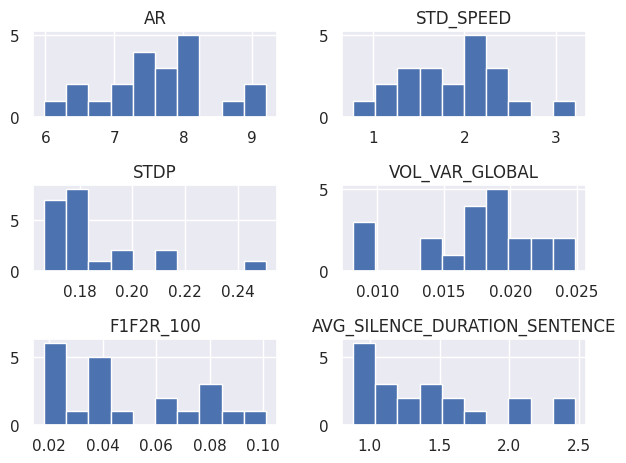

In [7]:
feat_df[feature_cols].hist()
plt.tight_layout()

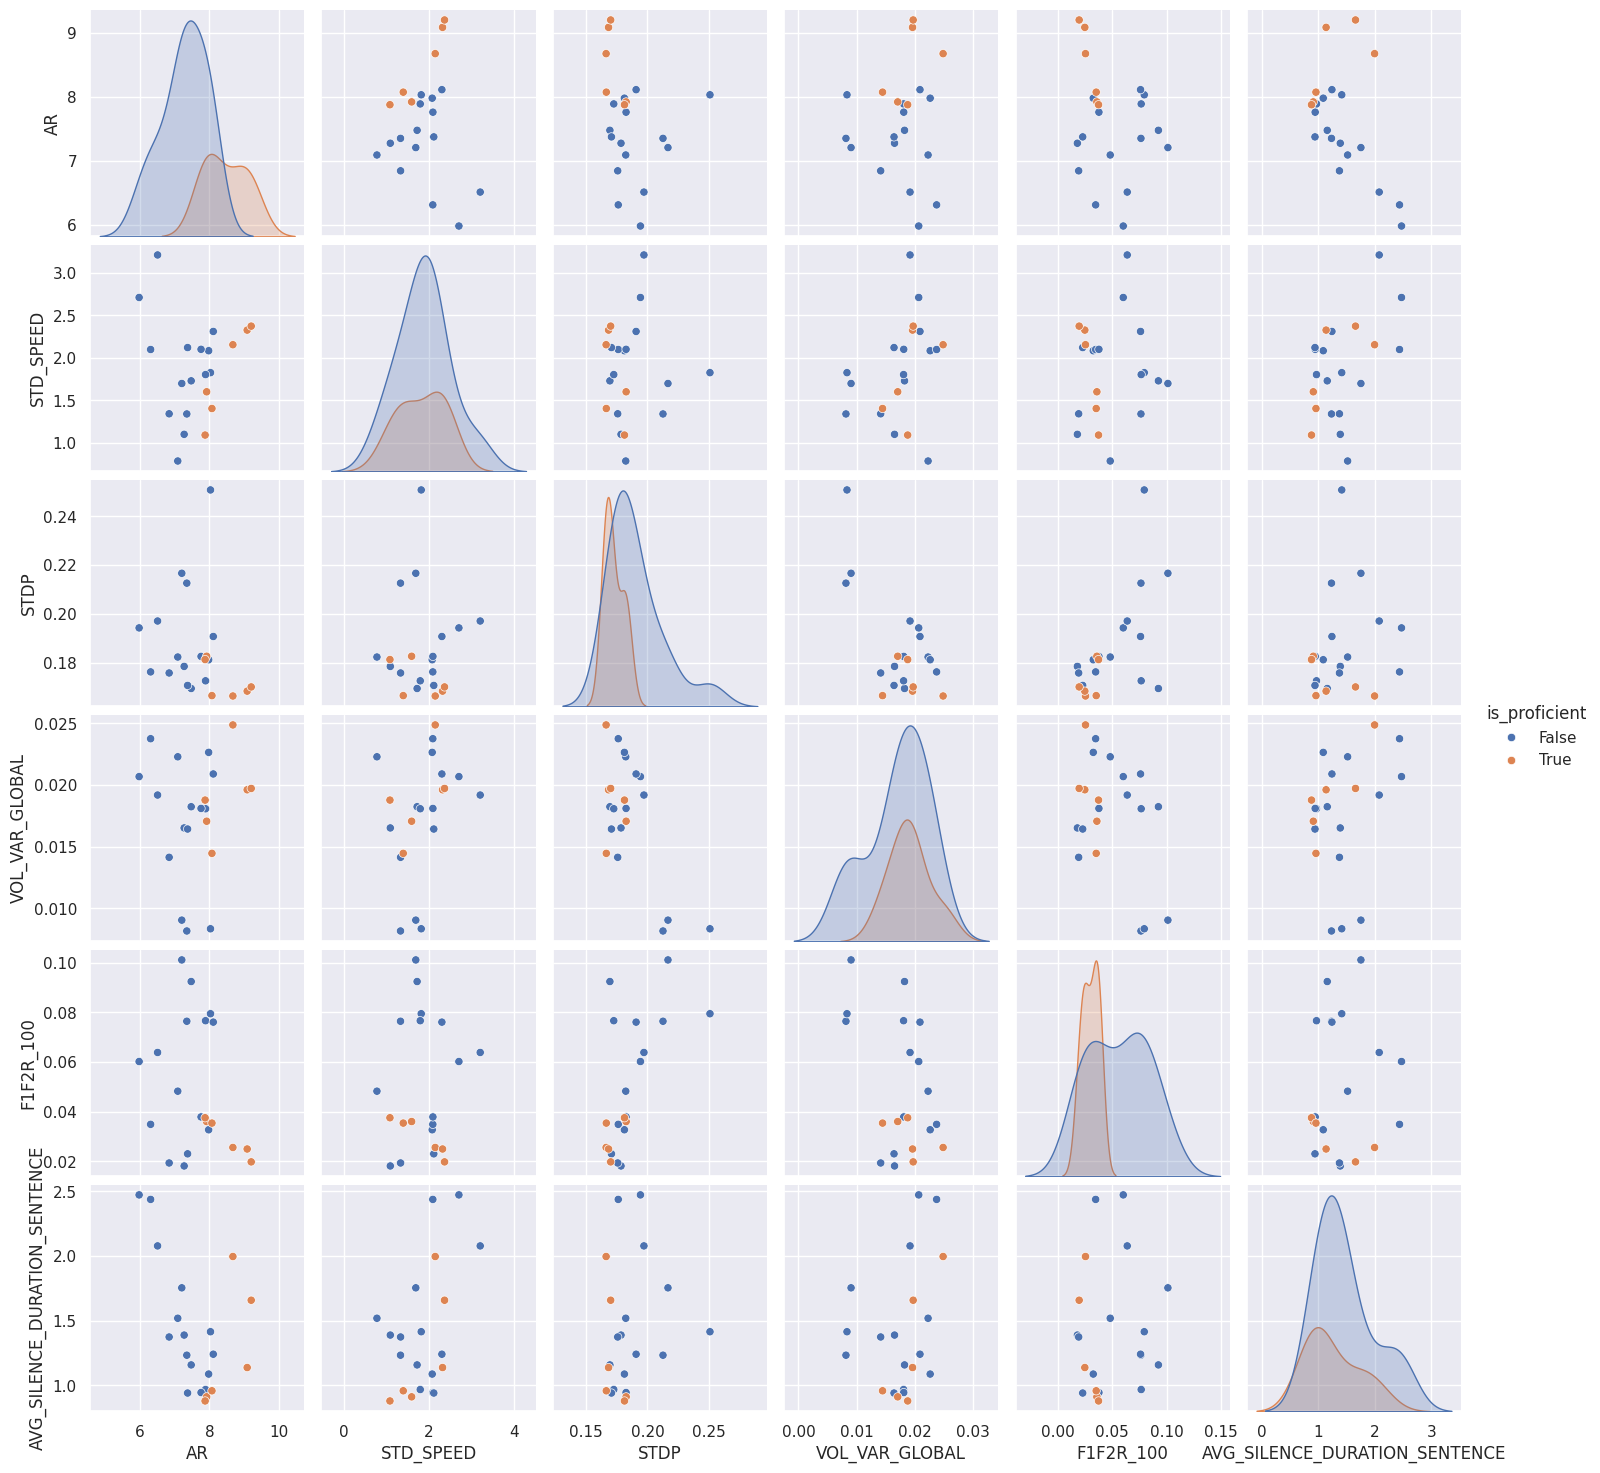

In [8]:
sns.pairplot(feat_df[[*feature_cols, target_col]], hue=target_col)

<Axes: >

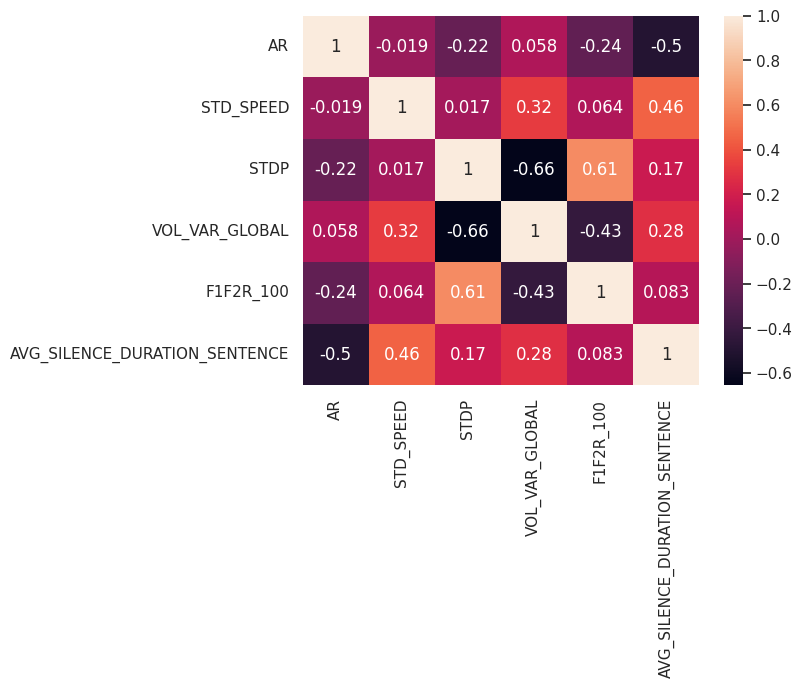

In [9]:
# correlation matrix
corr = feat_df[feature_cols].corr()
sns.heatmap(corr, annot=True)

In [10]:
# check multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

extended_feat_df = feat_df[feature_cols].copy()
extended_feat_df["const"] = 1

vif = pd.DataFrame()
X = extended_feat_df.to_numpy()
vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif["features"] = [*feature_cols, "const"]

display(vif)

,VIF Factor,features
0,1.546944,AR
1,1.465331,STD_SPEED
2,2.865164,STDP
3,2.660158,VOL_VAR_GLOBAL
4,1.665171,F1F2R_100
5,2.224283,AVG_SILENCE_DURATION_SENTENCE
6,454.303306,const


In [11]:
# firth logistic regression
from firthlogist import FirthLogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(feat_df[feature_cols])
X = scaler.transform(feat_df[feature_cols])
y = feat_df[target_col].astype(int).to_numpy()

clf = FirthLogisticRegression()
clf.fit(X, y)
display(pd.Series(dict(zip(feature_cols, clf.coef_.squeeze()))))
display(clf.summary(xname=feature_cols))

AR                               3.077753
STD_SPEED                       -1.534079
STDP                            -0.292574
VOL_VAR_GLOBAL                  -0.330151
F1F2R_100                       -0.414282
AVG_SILENCE_DURATION_SENTENCE   -0.309535
dtype: float64

                                    coef    std err     [0.025       0.975]     p-value
-----------------------------  ---------  ---------  ---------  -----------  ----------
AR                              3.07775    1.56199    0.539425  10.3826      0.00630975
STD_SPEED                      -1.53408    1.21432   -6.66768    0.582551    0.141235
STDP                           -0.292574   1.03821   -4.21446    2.41988     0.710166
VOL_VAR_GLOBAL                 -0.330151   1.09705   -7.3637     2.85665     0.144393
F1F2R_100                      -0.414282   0.900715  -3.35141    1.58688     0.128917
AVG_SILENCE_DURATION_SENTENCE  -0.309535   1.09996   -3.3519     2.60294     0.380499
Intercept                      -2.0778     1.13939   -7.21      -0.00122249  0.0483956

Log-Likelihood: -2.7452
Newton-Raphson iterations: 14



None